In [1]:
from rdkit import Chem

import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from tqdm.auto import tqdm

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import CalcNumHBA
from rdkit.Chem.rdMolDescriptors import CalcNumHBD
import os
import matplotlib.pyplot as plt

## bring DB --> primary processing

In [3]:
org_syn_col = ['vol', 'issue', 'IUPAC', 'Smiles', 'elu1', 'elu2', 'ratio1', 'ratio2', 'Rf', 'doi', 'link'] 

# 석우 수집 데이터

file_path = "/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/DB/collecting/qualified_TLC(org_syn)/Rf_ksw.xlsm"

sw_data = pd.read_excel(file_path)
sw_data = sw_data.iloc[:, :11]
sw_data.drop(0, axis=0, inplace=True)
sw_data.columns=org_syn_col
sw_data

,vol,issue,IUPAC,Smiles,elu1,elu2,ratio1,ratio2,Rf,doi,link
1,47,7,cholane-24-al,C(CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]...,Benzene,NaN,1,0,0.76,10.15227/orgsyn.047.0025,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
2,47,7,cholane-24-ol,C(CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]...,Benzene,NaN,1,0,0.19,10.15227/orgsyn.047.0025,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
3,48,6,dibenzyl ketoxime,C(C1=CC=CC=C1)C(=NO)CC1=CC=CC=C1,Chloroform,Methanol,95,5,0.8,10.15227/orgsyn.048.0020,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
4,48,6,aziridine,N1CC1,Chloroform,Methanol,95,5,0.8,10.15227/orgsyn.048.0020,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
5,48,11,t-Butyl diazoacetate,[N+](=[N-])=CC(=O)OC(C)(C)C,Chloroform,NaN,1,0,0.72,10.15227/orgsyn.048.0036,https://www.orgsyn.org/demo.aspx?prep=CV5P0179
...,...,...,...,...,...,...,...,...,...,...,...
388,86,19,"2-Bromo-N-[(1S)-1-(hydroxymethyl)-2,2-dimethyl...",CC(C)(C)[C@@H](CO)NC(=O)C1=C(Br)C=CC=C1,Hex,Acetone,2,1,0.14,10.15227/orgsyn.086.0181,https://www.orgsyn.org/demo.aspx?prep=V86P0181
389,86,19,"2-(2-Bromophenyl)-4-(1,1-dimethylethyl)-4,5-di...",CC(C)(C)[C@H]1COC(=N1)C1=C(Br)C=CC=C1,Hex,EA,4,1,0.27,10.15227/orgsyn.086.0181,https://www.orgsyn.org/demo.aspx?prep=V86P0181
390,86,17,Methyl 2-(2-acetylphenyl)acetate,COC(=O)CC1=C(C=CC=C1)C(C)=O,Hex,EA,4,1,0.43,10.15227/orgsyn.086.0161,https://www.orgsyn.org/demo.aspx?prep=V86P0161
391,86,17,methyl 2-(2-acetylphenyl)-2-phenylacetate,COC(=O)C(C1=CC=CC=C1)C1=C(C=CC=C1)C(C)=O,Hex,EA,4,1,0.53,10.15227/orgsyn.086.0161,https://www.orgsyn.org/demo.aspx?prep=V86P0161


In [4]:
# 아인님 수집 데이터

file_path = "/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/DB/collecting/qualified_TLC(org_syn)/Rf_ain.xlsm"

ain_data = pd.read_excel(file_path)
ain_data = ain_data.iloc[:, :11]
ain_data.drop(0, axis=0, inplace=True)
ain_data.columns=org_syn_col
ain_data

,vol,issue,IUPAC,Smiles,elu1,elu2,ratio1,ratio2,Rf,doi,link
1,81,8,N-(tert-Butoxycarbonyl)-O-(p-toluenesulfonyl)-...,COC([C@@H](NC(=O)OC(C)(C)C)COS(=O)(=O)C1=CC=C(...,PE,EA,3,1,0.24,10.15227/orgsyn.081.0077,https://www.orgsyn.org/demo.aspx?prep=v81p0077
2,81,8,N-(tert-Butoxycarbonyl)-β-iodoalanine methyl e...,COC([C@@H](NC(=O)OC(C)(C)C)CI)=O,PE,EA,3,1,0.6,10.15227/orgsyn.081.0077,https://www.orgsyn.org/demo.aspx?prep=v81p0077
3,81,10,5-bromoisoquinoline,BrC1=C2C=CN=CC2=CC=C1,DCM,diethyl ether,9,1,0.3,10.15227/orgsyn.081.0098,https://www.orgsyn.org/demo.aspx?prep=v81p0098
4,81,10,5-bromo-8-nitroisoquinoline,BrC1=C2C=CN=CC2=C(C=C1)[N+](=O)[O-],DCM,EA,9,1,0.57,10.15227/orgsyn.081.0098,https://www.orgsyn.org/demo.aspx?prep=v81p0098
5,81,12,N-Phenyl-(5R)-hydroxymethyl-2-oxazolidinone,OC[C@H]1CN(C(=O)O1)C1=CC=CC=C1,EA,Hex,1,1,0.13,10.15227/orgsyn.081.0112,https://www.orgsyn.org/demo.aspx?prep=v81p0112
...,...,...,...,...,...,...,...,...,...,...,...
110,86,14,"(1R,2R)-1,2- diphenylethane-1,2-diol",C1(=CC=CC=C1)[C@H]([C@H](O)C1=CC=CC=C1)O,Hex,diethyl ether,1,1,0.52,10.15227/orgsyn.086.0130,https://www.orgsyn.org/demo.aspx?prep=v86p0130
111,86,15,"3,3'-Di-(tert-butoxycarbonyl)-aminodipropylamine",CC(C)(C)OC(=O)NCCCNCCCNC(=O)OC(C)(C)C,Methanol,DCM,5,95,0,10.15227/orgsyn.086.0141,https://www.orgsyn.org/demo.aspx?prep=v86p0141
112,86,15,NaN,CC(C)(C)OC(=O)NCCCN(CCCNC(=O)OC(C)(C)C)C1=NC(C...,Methanol,DCM,5,95,0.3,10.15227/orgsyn.086.0141,https://www.orgsyn.org/demo.aspx?prep=v86p0141
113,86,15,NaN,CC(C)(C)OC(=O)N1CCN(CC1)C1=NC(=NC(=N1)N1CCN(CC...,Methanol,DCM,5,95,0.35,10.15227/orgsyn.086.0141,https://www.orgsyn.org/demo.aspx?prep=v86p0141


In [5]:
# 민석님 수집 데이터

file_path = "/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/DB/collecting/qualified_TLC(org_syn)/Rf_kms.xlsm"

ms_data = pd.read_excel(file_path)
ms_data = ms_data.iloc[:, :11]
ms_data.drop(0, axis=0, inplace=True)
ms_data.columns=org_syn_col
ms_data

,vol,issue,IUPAC,Smiles,elu1,elu2,ratio1,ratio2,Rf,doi,link
1,102,1,(S)-1-((R)-oxiran-2-yl)prop-2-en-1-ol,O1[C@H](C1)[C@H](C=C)O,Hex,EA,0.6,0.4,0.26,10.15227/orgsyn.102.0001,https://www.orgsyn.org/demo.aspx?prep=v102p0001
2,102,4,"2-(3-Iodopropyl)isoindoline-1,3-dione",ICCCN1C(C2=CC=CC=C2C1=O)=O,Hex,EA,0.8,0.2,0.43,10.15227/orgsyn.102.0064,https://www.orgsyn.org/demo.aspx?prep=v102p0064
3,102,4,"2-(3-hydroxypropyl)isoindoline-1,3-dione",OCCCN1C(C2=CC=CC=C2C1=O)=O,Hex,EA,0.4,0.6,0.45,10.15227/orgsyn.102.0064,https://www.orgsyn.org/demo.aspx?prep=v102p0064
4,102,4,"2-(3-(1-Nitrocyclohexyl)propyl)isoindoline-1,3...",[N+](=O)([O-])C1(CCCCC1)CCCN1C(C2=CC=CC=C2C1=O)=O,Hex,EA,0.8,0.2,0.35,10.15227/orgsyn.102.0064,https://www.orgsyn.org/demo.aspx?prep=v102p0064
5,102,5,1-Cyclohexyl-4-chlorobenzene,C1(CCCCC1)C1=CC=C(C=C1)Cl,PE,NaN,1,0,0.8,10.15227/orgsyn.102.0086,https://www.orgsyn.org/demo.aspx?prep=v102p0086
...,...,...,...,...,...,...,...,...,...,...,...
930,87,36,2-aminobenzyl alcohol,NC1=C(CO)C=CC=C1,Hex,EA,0.7,0.3,0.1,10.15227/orgsyn.087.0339,https://www.orgsyn.org/demo.aspx?prep=v87p0339
931,87,36,2-nitrobenzaldehyde,[N+](=O)([O-])C1=C(C=O)C=CC=C1,Hex,EA,0.7,0.3,0.43,10.15227/orgsyn.087.0339,https://www.orgsyn.org/demo.aspx?prep=v87p0339
932,87,36,(2-(2-nitrobenzylamino)phenyl)methanol,[N+](=O)([O-])C1=C(CNC2=C(C=CC=C2)CO)C=CC=C1,Hex,EA,0.7,0.3,0.26,10.15227/orgsyn.087.0339,https://www.orgsyn.org/demo.aspx?prep=v87p0339
933,87,36,"5H-Indazolo-[3,2-b]benzo[d]-1,3-oxazine",C1=CC=CC2=C1N1C(OC2)=C2C=CC=CC2=N1,Hex,EA,0.7,0.3,0.45,10.15227/orgsyn.087.0339,https://www.orgsyn.org/demo.aspx?prep=v87p0339


In [6]:
# 데이터 통일 및 결측치 제거
def is_valid_float(x):
    try:
        float(x)
        return True
    except:
        return False

org_syn_df_raw = pd.concat([sw_data, ain_data, ms_data], axis=0, ignore_index = True)
org_syn_df = org_syn_df_raw[['Smiles', 'elu1', 'elu2', 'ratio1', 'ratio2', 'Rf', 'link']]
org_syn_df.dropna(subset=['Smiles', 'Rf'], inplace = True)    #Smiles nan 제거,  Rf nan 제거
org_syn_df.dropna(subset = ['elu1', 'elu2'], how = 'all', inplace = True) #eluent1,2 모두 없는거 제거
org_syn_df = org_syn_df[org_syn_df['ratio1']!=0]
mask_Rf = org_syn_df['Rf'].apply(is_valid_float) # 가끔 Rf 가 문자열로 보관되는데, float으로 변환 가능하지만, 0.4 - 0.45 이런건 안되니 걍 지우자
org_syn_df = org_syn_df[mask_Rf]
mask_ratio1 = org_syn_df['ratio1'].apply(is_valid_float) # 이상한 ratio 삭제
org_syn_df = org_syn_df[mask_ratio1]
mask_ratio2 = org_syn_df['ratio2'].apply(is_valid_float) # 이상한 ratio 삭제
org_syn_df = org_syn_df[mask_ratio2]
org_syn_df.reset_index(drop=True, inplace=True)

print(f'raw개수: {len(org_syn_df)}')


raw개수: 1433


/tmp/ipykernel_227971/4276825837.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  org_syn_df.dropna(subset=['Smiles', 'Rf'], inplace = True)    #Smiles nan 제거,  Rf nan 제거
/tmp/ipykernel_227971/4276825837.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  org_syn_df.dropna(subset = ['elu1', 'elu2'], how = 'all', inplace = True) #eluent1,2 모두 없는거 제거


In [6]:
"""# 이상한 용액 있는 파일 추적 (용액 이름 이상하게 명명해서 converter에 넣기 부적절한것)
def file_finder_weird_eluent(name, eluent):
    if name == "sw":
        file = sw_data
        print('석우 수집: ')
    elif name == 'ain':
        file = ain_data
        print('아인 수집: ')
    elif name == 'ms':
        file = ms_data
        print('민석 수집: ')
    a=None
    mask = ((file['elu1']==eluent) | (file['elu2']==eluent))
    ff = file[mask]
    if (len(ff)>0):
        a=file
        print(f'{ff}')
    if a is None:
        print('해당 eluent 있는 파일 없음\n')
        return




file_finder_weird_eluent('sw','https://www.orgsyn.org/demo.aspx?prep=v81p0098')
file_finder_weird_eluent('ain','https://www.orgsyn.org/demo.aspx?prep=v81p0098')
file_finder_weird_eluent('ms','https://www.orgsyn.org/demo.aspx?prep=v81p0098')

file_finder_weird_eluent('sw','H')
file_finder_weird_eluent('ain','H')
file_finder_weird_eluent('ms','H')"""

'# 이상한 용액 있는 파일 추적 (용액 이름 이상하게 명명해서 converter에 넣기 부적절한것)\ndef file_finder_weird_eluent(name, eluent):\n    if name == "sw":\n        file = sw_data\n        print(\'석우 수집: \')\n    elif name == \'ain\':\n        file = ain_data\n        print(\'아인 수집: \')\n    elif name == \'ms\':\n        file = ms_data\n        print(\'민석 수집: \')\n    a=None\n    mask = ((file[\'elu1\']==eluent) | (file[\'elu2\']==eluent))\n    ff = file[mask]\n    if (len(ff)>0):\n        a=file\n        print(f\'{ff}\')\n    if a is None:\n        print(\'해당 eluent 있는 파일 없음\n\')\n        return\n\n\n\n\nfile_finder_weird_eluent(\'sw\',\'https://www.orgsyn.org/demo.aspx?prep=v81p0098\')\nfile_finder_weird_eluent(\'ain\',\'https://www.orgsyn.org/demo.aspx?prep=v81p0098\')\nfile_finder_weird_eluent(\'ms\',\'https://www.orgsyn.org/demo.aspx?prep=v81p0098\')\n\nfile_finder_weird_eluent(\'sw\',\'H\')\nfile_finder_weird_eluent(\'ain\',\'H\')\nfile_finder_weird_eluent(\'ms\',\'H\')'

In [ ]:
'''# convert에 도입하기 부적절한 용액 데이터를 아예 raw 파일에서 추적하여 삭제
# raw추적해서 삭제하는 이유: 매번 업데이트 때마다 converter업뎃 하는데, 이때 자꾸 재등장하면 안되니깐

def hunting(who, file_name, eluent):
    if who == 'sw':
        path = "/home/ufslab223/Shared/KSW/GPT/data_extracted_gpt"
    elif who =='ain':
        path = '/home/ufslab223/Shared/ains/GPT/data_extracted_gpt'
    file = pd.read_csv(path+'/'+ file_name)
    mask = ((file['eluent1']!=eluent) & (file['eluent2']!=eluent))
    file_ = file[mask]
    file_.reset_index(drop=True, inplace=True)
    file_.to_csv(path+'/'+ file_name, index=False)

hunting('ain', 'datatable522.csv', 'AT')'''

In [7]:
##### eluent를 smiles로 변경하기 전에, elu 이름 표준화 및, smiles, 정보들과 매칭 시스템 #####


#필요 없는 칼럼 지우고 eluent 이름 통일한 후에 통일한 이름 바탕으로, smiles 로 변환하기
elu_list1 = list(org_syn_df['elu1'].drop_duplicates())
elu_list2 = list(org_syn_df['elu2'].drop_duplicates())
elu_list = list(pd.Series(elu_list1 + elu_list2).drop_duplicates()) # set 대신 이렇게 써야 요소 순서가 고정됨(등장 순서)
elu_list

# 처음 보는 eluent (elu_to_key_df에 없는) 추가되면 대응되는 key 지정해주기
elu_to_key_df = pd.read_csv('elu_to_key_df.csv') 
elu_df = pd.read_csv('eluent_standard.csv')
new_eluent=[]
for elu in elu_list:
    if elu in list(elu_to_key_df['elu_raw']):
        continue
    else:
        new_eluent.append(elu)

# 하나씩 대응되는 표준 key 지정
# eluent_standard_name.csv 에 각 number key와 eluent 표준명을 기재해놓음.
# 만약 여기에 없는 새로운 eluent가 추가되면 number key 하나 추가하여 갱신하면 됨.
elu_key=[]
for elu in new_eluent:
    elu_df = pd.read_csv('eluent_standard.csv') # for 문 내에서 업데이트 된 거 새로 불러오기
    key = int(input(f'{elu} 의 key 지정 --> '))
    elu_key.append(key)
    # 만약 추가되는 eluent가 이름만 새로운게 아니라 새로운 화학종이면 elu_standard에서 추가해놔야함
    if key > len(elu_df):
        std_name = input(f'{key}와 매칭될 표준 이름 입력: ')
        print(key, std_name)
        smiles = input(f'{key}와 매칭될 smiles 입력 (자동 canonicalize 해줄것임): ')
        if smiles == '??':
            cano_smiles = smiles # 논문 작성자가 무슨 용매를 의미한건지 명확하지 않을때 임시로 채워넣는것
        else:
            cano_smiles = Chem.MolToSmiles((Chem.MolFromSmiles(smiles)), canonical = True)
        density = input(f'{key}와 매칭될 밀도 입력: ')

        extra_eleunt_inform = pd.DataFrame({'key': [key],'std_name': [std_name],'567_Smiles': [cano_smiles],'hex_Smiles': [cano_smiles], 'density': [density]})
        elu_df = pd.concat([elu_df, extra_eleunt_inform], axis=0)
        elu_df.to_csv('eluent_standard.csv', index=False) # elu_standard 업데이트 저장


extra_elu2key_df = pd.DataFrame({'elu_raw': new_eluent, 'elu_key': elu_key})
elu_to_key_df = pd.concat([elu_to_key_df, extra_elu2key_df], axis=0)
elu_to_key_df.to_csv('elu_to_key_df.csv', index=False) # elu to key 업데이트 저장

In [8]:
# eluent --> key --> smiles 변환

elu_to_key_df = pd.read_csv('elu_to_key_df.csv') 
elu_to_key_converter = dict(zip(elu_to_key_df['elu_raw'], elu_to_key_df['elu_key']))

elu_df = pd.read_csv('eluent_standard.csv')
key_to_567smiles_converter = dict(zip(elu_df['key'], elu_df['567_Smiles']))
key_to_smiles_converter = dict(zip(elu_df['key'], elu_df['hex_Smiles']))

elu1_list_org = org_syn_df['elu1']
elu2_list_org = org_syn_df['elu2']

# -----------PE --> hex 버전 ---------------

org_syn_df['elu1'] = [key_to_smiles_converter[elu_to_key_converter[name]] for name in elu1_list_org]
org_syn_df['elu2']  = [key_to_smiles_converter[elu_to_key_converter[name]] for name in elu2_list_org]

# ratio 칼럼 정리

org_syn_df['ratio1'] = org_syn_df['ratio1'].apply(lambda x: float(x) if not isinstance(x, float) else x)
org_syn_df['ratio2'] = org_syn_df['ratio2'].apply(lambda x: float(x) if not isinstance(x, float) else x)
org_syn_df['Rf'] = org_syn_df['Rf'].apply(lambda x: float(x) if not isinstance(x, float) else x)

#----------PE --> 567버전 ------------------
from copy import deepcopy
org_syn_df_567 = deepcopy(org_syn_df)
org_syn_df_567['elu1'] = [key_to_567smiles_converter[elu_to_key_converter[name]] for name in elu1_list_org]
org_syn_df_567['elu2']  = [key_to_567smiles_converter[elu_to_key_converter[name]] for name in elu2_list_org]

In [9]:
org_syn_df

,Smiles,elu1,elu2,ratio1,ratio2,Rf,link
0,C(CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]...,c1ccccc1,NaN,1.0,0.0,0.76,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
1,C(CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]...,c1ccccc1,NaN,1.0,0.0,0.19,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
2,C(C1=CC=CC=C1)C(=NO)CC1=CC=CC=C1,ClC(Cl)Cl,CO,95.0,5.0,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
3,N1CC1,ClC(Cl)Cl,CO,95.0,5.0,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
4,[N+](=[N-])=CC(=O)OC(C)(C)C,ClC(Cl)Cl,NaN,1.0,0.0,0.72,https://www.orgsyn.org/demo.aspx?prep=CV5P0179
...,...,...,...,...,...,...,...
1428,NC1=C(CO)C=CC=C1,CCCCCC,CCOC(C)=O,0.7,0.3,0.10,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1429,[N+](=O)([O-])C1=C(C=O)C=CC=C1,CCCCCC,CCOC(C)=O,0.7,0.3,0.43,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1430,[N+](=O)([O-])C1=C(CNC2=C(C=CC=C2)CO)C=CC=C1,CCCCCC,CCOC(C)=O,0.7,0.3,0.26,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1431,C1=CC=CC2=C1N1C(OC2)=C2C=CC=CC2=N1,CCCCCC,CCOC(C)=O,0.7,0.3,0.45,https://www.orgsyn.org/demo.aspx?prep=v87p0339


In [10]:
import sys
sys.path.append('../../../')
from functions import delete_weird_mol_and_None_except_Nan, delete_metal_mol_except_Nan


# ---------------PE_hex 버전

print('1')
org_syn_df = delete_weird_mol_and_None_except_Nan(org_syn_df, 'Smiles')
print('2')
org_syn_df = delete_metal_mol_except_Nan(org_syn_df, 'Smiles')
print('3')
org_syn_df = delete_weird_mol_and_None_except_Nan(org_syn_df, 'elu1')
print('4')
org_syn_df = delete_metal_mol_except_Nan(org_syn_df, 'elu1')
print('5')
org_syn_df = delete_weird_mol_and_None_except_Nan(org_syn_df, 'elu2')
print('6')
org_syn_df = delete_metal_mol_except_Nan(org_syn_df, 'elu2')
print('7')


# ---------------PE_567 버전

print('1')
org_syn_df_567 = delete_weird_mol_and_None_except_Nan(org_syn_df_567, 'Smiles')
print('2')
org_syn_df_567 = delete_metal_mol_except_Nan(org_syn_df_567, 'Smiles')
print('3')
org_syn_df_567 = delete_weird_mol_and_None_except_Nan(org_syn_df_567, 'elu1')
print('4')
org_syn_df_567 = delete_metal_mol_except_Nan(org_syn_df_567, 'elu1')
print('5')
org_syn_df_567 = delete_weird_mol_and_None_except_Nan(org_syn_df_567, 'elu2')
print('6')
org_syn_df_567 = delete_metal_mol_except_Nan(org_syn_df_567, 'elu2')
print('7')

1
94번째 분자 mol=None (smiles가 아닌 값)
204번째 분자 mol=None (smiles가 아닌 값)
209번째 분자 mol=None (smiles가 아닌 값)
210번째 분자 mol=None (smiles가 아닌 값)
319번째 분자 mol=None (smiles가 아닌 값)
320번째 분자 mol=None (smiles가 아닌 값)
323번째 분자 mol=None (smiles가 아닌 값)
325번째 분자 mol=None (smiles가 아닌 값)
332번째 분자 mol=None (smiles가 아닌 값)
364번째 분자 mol=None (smiles가 아닌 값)
892번째 분자 mol=None (smiles가 아닌 값)
2


[13:47:13] SMILES Parse Error: syntax error while parsing: Methyl
[13:47:13] SMILES Parse Error: check for mistakes around position 1:
[13:47:13] Methyl
[13:47:13] ^
[13:47:13] SMILES Parse Error: Failed parsing SMILES 'Methyl' for input: 'Methyl'
[13:47:13] SMILES Parse Error: unclosed ring for input: 'CC(C(O)C1=CC=CC=C1)N(CC1=CC=CC=C1)S(=O)(=O)C1=C(C)C=C(C)C=C2C'
[13:47:13] SMILES Parse Error: unclosed ring for input: 'CC(C)[C@@H](O)C(C)C(=O)OC(C(C)N(CC1=CC=CC=C1)S(=O)(=O)C1=C(C)C=C(C)C=C1C)C1=CC=CC=C2'
[13:47:13] SMILES Parse Error: unclosed ring for input: 'CC(C)[C@@H](O)C(C)C(=O)OC(C(C)N(CC1=CC=CC=C1)S(=O)(=O)C1=C(C)C=C(C)C=C1C)C1=CC=CC=C2'
[13:47:13] SMILES Parse Error: unclosed ring for input: 'OC(=O)C1CCCN1C(=O)OCC1=CC=CC=C2'
[13:47:13] SMILES Parse Error: unclosed ring for input: 'NC(=O)C1CCCN1C(=O)OCC1=CC=CC=C2'
[13:47:13] SMILES Parse Error: unclosed ring for input: 'O=C(OCC1=CC=CC=C1)N1CCC[C@H]2C#N'
[13:47:13] SMILES Parse Error: unclosed ring for input: 'O=C(OCC1=CC=CC=C1)

173번째 분자 금속원소 포함됨
467번째 분자 금속원소 포함됨
685번째 분자 금속원소 포함됨
925번째 분자 금속원소 포함됨
926번째 분자 금속원소 포함됨
927번째 분자 금속원소 포함됨
929번째 분자 금속원소 포함됨
1064번째 분자 금속원소 포함됨
3
4
5
6
7
1
94번째 분자 mol=None (smiles가 아닌 값)
204번째 분자 mol=None (smiles가 아닌 값)
209번째 분자 mol=None (smiles가 아닌 값)
210번째 분자 mol=None (smiles가 아닌 값)
319번째 분자 mol=None (smiles가 아닌 값)
320번째 분자 mol=None (smiles가 아닌 값)
323번째 분자 mol=None (smiles가 아닌 값)
325번째 분자 mol=None (smiles가 아닌 값)
332번째 분자 mol=None (smiles가 아닌 값)
364번째 분자 mol=None (smiles가 아닌 값)
892번째 분자 mol=None (smiles가 아닌 값)
2


[13:47:14] SMILES Parse Error: syntax error while parsing: Methyl
[13:47:14] SMILES Parse Error: check for mistakes around position 1:
[13:47:14] Methyl
[13:47:14] ^
[13:47:14] SMILES Parse Error: Failed parsing SMILES 'Methyl' for input: 'Methyl'
[13:47:14] SMILES Parse Error: unclosed ring for input: 'CC(C(O)C1=CC=CC=C1)N(CC1=CC=CC=C1)S(=O)(=O)C1=C(C)C=C(C)C=C2C'
[13:47:14] SMILES Parse Error: unclosed ring for input: 'CC(C)[C@@H](O)C(C)C(=O)OC(C(C)N(CC1=CC=CC=C1)S(=O)(=O)C1=C(C)C=C(C)C=C1C)C1=CC=CC=C2'
[13:47:14] SMILES Parse Error: unclosed ring for input: 'CC(C)[C@@H](O)C(C)C(=O)OC(C(C)N(CC1=CC=CC=C1)S(=O)(=O)C1=C(C)C=C(C)C=C1C)C1=CC=CC=C2'
[13:47:14] SMILES Parse Error: unclosed ring for input: 'OC(=O)C1CCCN1C(=O)OCC1=CC=CC=C2'
[13:47:14] SMILES Parse Error: unclosed ring for input: 'NC(=O)C1CCCN1C(=O)OCC1=CC=CC=C2'
[13:47:14] SMILES Parse Error: unclosed ring for input: 'O=C(OCC1=CC=CC=C1)N1CCC[C@H]2C#N'
[13:47:14] SMILES Parse Error: unclosed ring for input: 'O=C(OCC1=CC=CC=C1)

173번째 분자 금속원소 포함됨
467번째 분자 금속원소 포함됨
685번째 분자 금속원소 포함됨
925번째 분자 금속원소 포함됨
926번째 분자 금속원소 포함됨
927번째 분자 금속원소 포함됨
929번째 분자 금속원소 포함됨
1064번째 분자 금속원소 포함됨
3
4
5
6
7


In [11]:
#Smiles canonicalize

#-------------PE hex 버전 -------------

org_syn_df = org_syn_df[(0<org_syn_df['Rf']) & (org_syn_df['Rf']<=1)]

# ratio1 > ratio2 되도록 정렬 --> 중복 데이터 판별시 필요
switch_ratio_mask = org_syn_df['ratio1']-org_syn_df['ratio2']<0

org_syn_df.loc[switch_ratio_mask, ['ratio1','ratio2']] = org_syn_df.loc[switch_ratio_mask, ['ratio2', 'ratio1']].values
org_syn_df.loc[switch_ratio_mask, ['elu1','elu2']] = org_syn_df.loc[switch_ratio_mask, ['elu2', 'elu1']].values

# compound smiles canonicalize 
org_syn_df.loc[:,'Smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True, canonical=True) for smiles in org_syn_df['Smiles']]

org_syn_df = org_syn_df.reset_index(drop=True)


#-------------PE 567 버전 -------------

org_syn_df_567 = org_syn_df_567[(0<org_syn_df_567['Rf']) & (org_syn_df_567['Rf']<=1)]

# ratio1 > ratio2 되도록 정렬 --> 중복 데이터 판별시 필요
switch_ratio_mask = org_syn_df_567['ratio1']-org_syn_df_567['ratio2']<0

org_syn_df_567.loc[switch_ratio_mask, ['ratio1','ratio2']] = org_syn_df_567.loc[switch_ratio_mask, ['ratio2', 'ratio1']].values
org_syn_df_567.loc[switch_ratio_mask, ['elu1','elu2']] = org_syn_df_567.loc[switch_ratio_mask, ['elu2', 'elu1']].values

# compound smiles canonicalize 
org_syn_df_567.loc[:,'Smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True, canonical=True) for smiles in org_syn_df_567['Smiles']]

org_syn_df_567 = org_syn_df_567.reset_index(drop=True)


### elu1,elu2 도 canonlicalize 완료!

In [12]:
org_syn_df['elu1'] = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) if pd.notna(s) else np.nan for s in org_syn_df['elu1']]
org_syn_df['elu2'] = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) if pd.notna(s) else np.nan for s in org_syn_df['elu2']]

In [13]:
org_syn_df_567['elu1'] = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) if pd.notna(s) else np.nan for s in org_syn_df_567['elu1']]
org_syn_df_567['elu2'] = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) if pd.notna(s) else np.nan for s in org_syn_df_567['elu2']]

# salt 제거

In [14]:
salt_mask =np.array(['.' in smiles for smiles in org_syn_df['Smiles']])
org_syn_df=org_syn_df[~salt_mask]
org_syn_df.reset_index(drop=True, inplace=True)

salt_mask =np.array(['.' in smiles for smiles in org_syn_df_567['Smiles']])
org_syn_df_567=org_syn_df_567[~salt_mask]
org_syn_df_567.reset_index(drop=True, inplace=True)

org_syn_df

,Smiles,elu1,elu2,ratio1,ratio2,Rf,link
0,C[C@H](CCC=O)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]...,c1ccccc1,NaN,1.0,0.0,0.76,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
1,C[C@H](CCCO)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]4...,c1ccccc1,NaN,1.0,0.0,0.19,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
2,ON=C(Cc1ccccc1)Cc1ccccc1,ClC(Cl)Cl,CO,95.0,5.0,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
3,C1CN1,ClC(Cl)Cl,CO,95.0,5.0,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
4,CC(C)(C)OC(=O)C=[N+]=[N-],ClC(Cl)Cl,NaN,1.0,0.0,0.72,https://www.orgsyn.org/demo.aspx?prep=CV5P0179
...,...,...,...,...,...,...,...
1373,Nc1ccccc1CO,CCCCCC,CCOC(C)=O,0.7,0.3,0.10,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1374,O=Cc1ccccc1[N+](=O)[O-],CCCCCC,CCOC(C)=O,0.7,0.3,0.43,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1375,O=[N+]([O-])c1ccccc1CNc1ccccc1CO,CCCCCC,CCOC(C)=O,0.7,0.3,0.26,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1376,c1ccc2c(c1)COc1c3ccccc3nn1-2,CCCCCC,CCOC(C)=O,0.7,0.3,0.45,https://www.orgsyn.org/demo.aspx?prep=v87p0339


In [20]:
org_syn_df.to_csv('../collecting/primary_processed_PE_hex/Org_syn_PE_hex.csv', index=False)
org_syn_df_567.to_csv('../collecting/primary_processed_PE_567/Org_syn_PE_567.csv', index=False)

In [15]:
org_syn_df= pd.read_csv('../collecting/primary_processed_PE_hex/Org_syn_PE_hex.csv')
org_syn_df_567=pd.read_csv('../collecting/primary_processed_PE_567/Org_syn_PE_567.csv')

In [16]:
org_syn_df

,Smiles,elu1,elu2,ratio1,ratio2,Rf,link
0,C[C@H](CCC=O)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]...,c1ccccc1,NaN,1.0,0.0,0.76,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
1,C[C@H](CCCO)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]4...,c1ccccc1,NaN,1.0,0.0,0.19,https://www.orgsyn.org/demo.aspx?prep=CV5P0242
2,ON=C(Cc1ccccc1)Cc1ccccc1,ClC(Cl)Cl,CO,95.0,5.0,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
3,C1CN1,ClC(Cl)Cl,CO,95.0,5.0,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083
4,CC(C)(C)OC(=O)C=[N+]=[N-],ClC(Cl)Cl,NaN,1.0,0.0,0.72,https://www.orgsyn.org/demo.aspx?prep=CV5P0179
...,...,...,...,...,...,...,...
1373,Nc1ccccc1CO,CCCCCC,CCOC(C)=O,0.7,0.3,0.10,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1374,O=Cc1ccccc1[N+](=O)[O-],CCCCCC,CCOC(C)=O,0.7,0.3,0.43,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1375,O=[N+]([O-])c1ccccc1CNc1ccccc1CO,CCCCCC,CCOC(C)=O,0.7,0.3,0.26,https://www.orgsyn.org/demo.aspx?prep=v87p0339
1376,c1ccc2c(c1)COc1c3ccccc3nn1-2,CCCCCC,CCOC(C)=O,0.7,0.3,0.45,https://www.orgsyn.org/demo.aspx?prep=v87p0339


(array([  3.,   1.,  12.,  38.,  68.,  96.,  98., 122., 129., 125., 116.,
        118.,  83.,  66.,  38.,  56.,  45.,  29.,  23.,  19.,  13.,   7.,
         12.,   8.,   9.,   2.,   5.,   6.,   3.,   4.,   1.,   1.,   6.,
          0.,   1.,   0.,   0.,   2.,   0.,   1.,   2.,   2.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([  33.006    ,   52.0485125,   71.091025 ,   90.1335375,
         109.17605  ,  128.2185625,  147.261075 ,  166.3035875,
         185.3461   ,  204.3886125,  223.431125 ,  242.4736375,
         261.51615  ,  280.5586625,  299.601175 ,  318.6436875,
         337.6862   ,  356.7287125,  375.771225 ,  394.8137375,
         413.85625  ,  432.8987625,  451.941275 ,  470.9837875,
         490.0263   ,  509.0688125,  528.111325 ,  547.1538375,
      

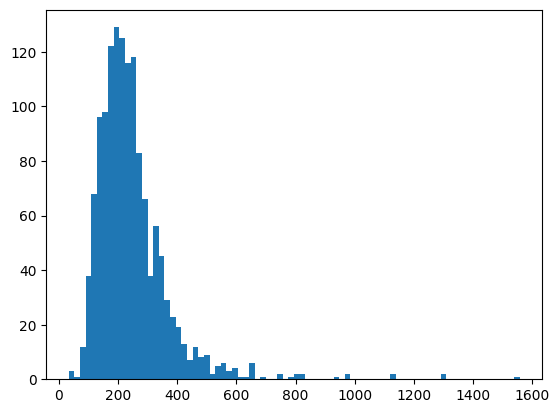

In [17]:
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors


plt.hist([Descriptors.MolWt(Chem.MolFromSmiles(sm)) for sm in org_syn_df['Smiles']], bins=80)

(array([ 4.,  6.,  7., 10., 21., 15., 13., 26., 28., 60., 27., 33., 44.,
        27., 91., 54., 21., 54., 35., 31., 90., 42., 42., 36., 29., 72.,
        38., 37., 23., 32., 44., 20., 34., 11., 33., 36., 19., 16., 20.,
         7., 23.,  4., 10., 12.,  6., 18.,  3.,  2.,  9.,  3.]),
 array([0.01  , 0.0294, 0.0488, 0.0682, 0.0876, 0.107 , 0.1264, 0.1458,
        0.1652, 0.1846, 0.204 , 0.2234, 0.2428, 0.2622, 0.2816, 0.301 ,
        0.3204, 0.3398, 0.3592, 0.3786, 0.398 , 0.4174, 0.4368, 0.4562,
        0.4756, 0.495 , 0.5144, 0.5338, 0.5532, 0.5726, 0.592 , 0.6114,
        0.6308, 0.6502, 0.6696, 0.689 , 0.7084, 0.7278, 0.7472, 0.7666,
        0.786 , 0.8054, 0.8248, 0.8442, 0.8636, 0.883 , 0.9024, 0.9218,
        0.9412, 0.9606, 0.98  ]),
 <BarContainer object of 50 artists>)

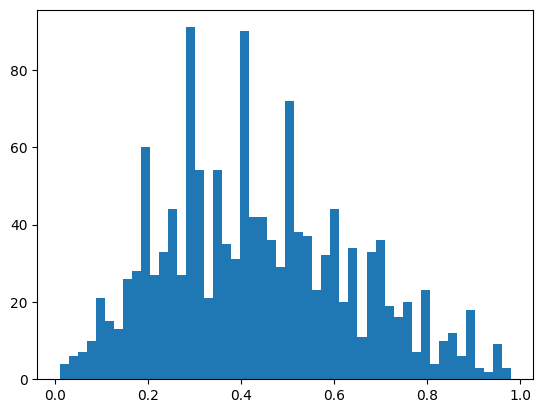

In [18]:
plt.hist(org_syn_df['Rf'], bins=50)

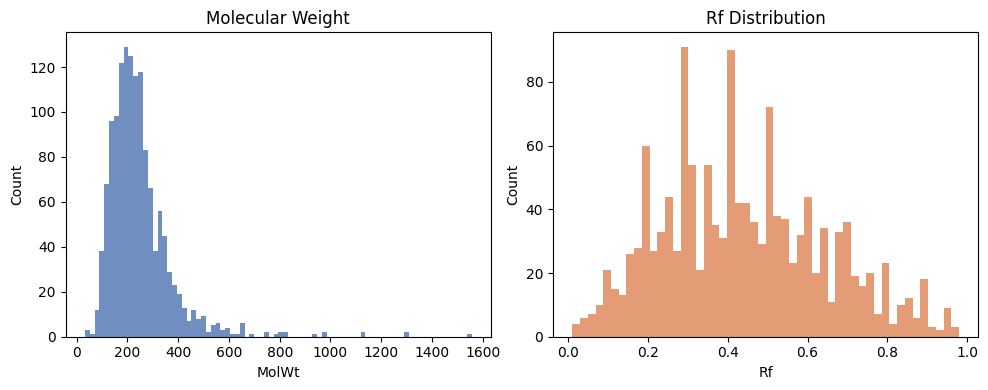

In [20]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors

molwt = [Descriptors.MolWt(Chem.MolFromSmiles(sm)) for sm in org_syn_df['Smiles']]
rf = org_syn_df['Rf']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# MolWt histogram
axes[0].hist(
    molwt,
    bins=80,
    color='#4C72B0',   # blue
    alpha=0.8
)
axes[0].set_title('Molecular Weight')
axes[0].set_xlabel('MolWt')
axes[0].set_ylabel('Count')

# Rf histogram
axes[1].hist(
    rf,
    bins=50,
    color='#DD8452',   # orange
    alpha=0.8
)
axes[1].set_title('Rf Distribution')
axes[1].set_xlabel('Rf')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


### Rf_type 추가:
#### 해당 논문에 정밀한 단위 Rf 있으면 정밀한 논문으로 취급
#### 0.05로 나누었을때 나머지 0 보다 크면 인정해줌

In [13]:
def set_Rf_type(df, not_005_ratio=0.5):
    from decimal import Decimal

    C_Rf_paper_list=[]
    for paper, paper_data in df.groupby(['title'], as_index=True):
        is_it_precise = np.array([Decimal(str(rf)) for rf in paper_data['Rf']]) % Decimal('0.05')
        # if (is_it_precise > 0).any():
        if len(is_it_precise[is_it_precise>0]) > len(is_it_precise)*not_005_ratio:
            C_Rf_paper_list.append(paper[0])

    df['Rf_type'] = ['C' if (title in C_Rf_paper_list) else 'Q' for title in df['title']]
    return df

In [14]:
LLM_df_final = set_Rf_type(LLM_df, 0.7)
LLM_df_567_final = set_Rf_type(LLM_df_567, 0.7)

In [15]:
len(LLM_df_final[LLM_df_final['Rf_type']=='C'])

7591

In [2]:
# ratio 부피비 --> 몰로 단위로 변경 및 정규화 

from rdkit.Chem import Descriptors as D
from tqdm.auto import tqdm

def vol_2_mol_ratio(df, ver):
    # ver : 'hex' or '567'
    elu_inform = pd.read_csv('/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/DB/data_process/eluent_standard.csv')
    d_converter = dict(zip(elu_inform['hex_Smiles'], elu_inform['density']))
    d_converter_567 = dict(zip(elu_inform['567_Smiles'], elu_inform['density']))

    for i in tqdm(range(len(df))):
        smiles1 = df.loc[i, 'elu1']
        ratio1 = df.loc[i, 'ratio1']
        smiles2 = df.loc[i, 'elu2']
        ratio2 = df.loc[i, 'ratio2']

        if ver == 'hex':
            converter = d_converter
        elif ver == '567':
            converter = d_converter_567

        if pd.notna(smiles1):
            df.at[i, 'ratio1'] = ratio1 * converter[smiles1] / D.MolWt(Chem.MolFromSmiles(smiles1))
        if pd.notna(smiles2):
            df.at[i, 'ratio2'] = ratio2 * converter[smiles2] / D.MolWt(Chem.MolFromSmiles(smiles2))

    # 몰 비 정규화
    ratio_total = df[['ratio1', 'ratio2']].sum(axis=1)
    df['ratio1'] = round((df['ratio1'] / ratio_total),6)
    df['ratio2'] = round((df['ratio2'] / ratio_total),6)
    # df['ratio1'] = (df['ratio1'] / ratio_total)
    # df['ratio2'] = (df['ratio2'] / ratio_total)

    return df



In [3]:
org_syn_df = pd.read_csv('../collecting/primary_processed_PE_hex/Org_syn_PE_hex.csv')


#---------PE hex 버전------------
org_syn_df = vol_2_mol_ratio(org_syn_df, ver = 'hex')

#---------PE 567 버전------------
#org_syn_df_567 = vol_2_mol_ratio(united_567, ver = '567')

#######################

# split 하기 전에, 나중에 학습 후 datapoint별 추적을 의한 sample_id 지정해두기
org_syn_df.loc[:,'sample_id'] = org_syn_df.index
org_syn_df

  0%|          | 0/1378 [00:00<?, ?it/s]

,Smiles,elu1,elu2,ratio1,ratio2,Rf,link,sample_id
0,C[C@H](CCC=O)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]...,c1ccccc1,NaN,1.000000,0.000000,0.76,https://www.orgsyn.org/demo.aspx?prep=CV5P0242,0
1,C[C@H](CCCO)[C@H]1CC[C@H]2[C@@H]3CCC4CCCC[C@]4...,c1ccccc1,NaN,1.000000,0.000000,0.19,https://www.orgsyn.org/demo.aspx?prep=CV5P0242,1
2,ON=C(Cc1ccccc1)Cc1ccccc1,ClC(Cl)Cl,CO,0.905609,0.094391,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083,2
3,C1CN1,ClC(Cl)Cl,CO,0.905609,0.094391,0.80,https://www.orgsyn.org/demo.aspx?prep=CV5P0083,3
4,CC(C)(C)OC(=O)C=[N+]=[N-],ClC(Cl)Cl,NaN,1.000000,0.000000,0.72,https://www.orgsyn.org/demo.aspx?prep=CV5P0179,4
...,...,...,...,...,...,...,...,...
1373,Nc1ccccc1CO,CCCCCC,CCOC(C)=O,0.636120,0.363880,0.10,https://www.orgsyn.org/demo.aspx?prep=v87p0339,1373
1374,O=Cc1ccccc1[N+](=O)[O-],CCCCCC,CCOC(C)=O,0.636120,0.363880,0.43,https://www.orgsyn.org/demo.aspx?prep=v87p0339,1374
1375,O=[N+]([O-])c1ccccc1CNc1ccccc1CO,CCCCCC,CCOC(C)=O,0.636120,0.363880,0.26,https://www.orgsyn.org/demo.aspx?prep=v87p0339,1375
1376,c1ccc2c(c1)COc1c3ccccc3nn1-2,CCCCCC,CCOC(C)=O,0.636120,0.363880,0.45,https://www.orgsyn.org/demo.aspx?prep=v87p0339,1376


In [4]:
path_raw = '/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/DB/Rf'
org_syn_df.to_csv(path_raw + '/org_syn_DB.csv', index=False)

In [5]:
import sys
sys.path.append('../../')
from make_graph_dataloader import MolToGraph

path_raw = '/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/DB/Rf'
compound_org_set = MolToGraph('Smiles', path_raw, 'org_syn_DB.csv', 'org_syn_test/compound_train.pt', elu_param = False)
elu1_org_set = MolToGraph('elu1', path_raw, 'org_syn_DB.csv', 'org_syn_test/elu1_valid.pt', elu_param = False)
elu2_org_set = MolToGraph('elu2', path_raw, 'org_syn_DB.csv', 'org_syn_test/elu2_valid.pt', elu_param = False)

Processing...


  0%|          | 0/1378 [00:00<?, ?it/s]

Done!
Processing...


  0%|          | 0/1378 [00:00<?, ?it/s]

Done!
Processing...


  0%|          | 0/1378 [00:00<?, ?it/s]

Done!


In [6]:
from torch_geometric.loader import DataLoader
from make_graph_dataloader import TripleGraphDataset

graph_org_set = TripleGraphDataset(
    compound_org_set,
    elu1_org_set,
    elu2_org_set
)

org_loader = DataLoader(graph_org_set, batch_size=500, shuffle=True)


In [7]:
org_iter = iter(org_loader)
next(org_iter)

[DataBatch(x=[8446, 48], edge_index=[2, 17590], edge_attr=[17590, 1], y=[500, 1], ratio=[500, 2], sample_id=[500, 1], batch=[8446], ptr=[501]),
 DataBatch(x=[2812, 48], edge_index=[2, 4640], edge_attr=[4640, 1], y=[500, 1], ratio=[500, 2], sample_id=[500, 1], batch=[2812], ptr=[501]),
 DataBatch(x=[2579, 48], edge_index=[2, 4166], edge_attr=[4166, 1], y=[500, 1], ratio=[500, 2], sample_id=[500, 1], batch=[2579], ptr=[501])]

In [9]:
from model_architecture import GCN_eluent_interaction_7_light as model_7_light

In [ ]:

def inverse_standardization(pred_nd_array, mean, std):
    return pred_nd_array * std + mean


# 일반적인 모델 불러오기

path = '/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/ckpt_paper/ckpt_<C_paper>_model7_light'
opt_ckpt = torch.load((path + '/opt_checkpoint.pt'))

#########################################################
#########################################################

device = torch.device('cuda')
model = model_7_light(version = 'all').to(device)
#model = model_5().to(device)
model.load_state_dict(opt_ckpt['model_state_dict'])


mean = np.load('/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/standardization/mean.npy')
std = np.load('/home/ufslab223/Shared/KSW/torch_geometric/TLC_RF/standardization/std.npy')


org_pred=[]
org_label=[]
org_id=[]
model.eval()
with torch.no_grad():
    for com_val, elu1_val, elu2_val in org_loader:
        org_label.append(com_val.y)
        org_id.append(com_val.sample_id)
        com_valid_batch = com_val.to(device)
        elu1_valid_batch = elu1_val.to(device)
        elu2_valid_batch = elu2_val.to(device)
        pred = model(com_valid_batch, elu1_valid_batch, elu2_valid_batch)
        org_pred.append(pred.cpu())

org_label = np.vstack(org_label)
org_label = inverse_standardization(org_label, mean, std)
org_label= org_label[:, 0].reshape(-1,1)
mask = ~np.isnan(org_label)
org_label=org_label[mask]

org_pred = np.vstack(org_pred)
org_pred = inverse_standardization(org_pred, mean, std)
org_pred = org_pred.reshape(-1,1)
org_pred=org_pred[mask]

(-0.1, 1.1)

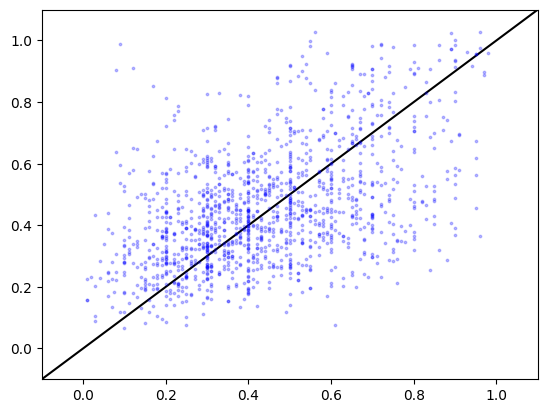

In [12]:
import matplotlib.pyplot as plt

x_line=np.arange(-2,3) #가시광선 nm범위
y_line=np.arange(-2,3)

plt.plot(x_line, y_line, c='black', zorder=1)
plt.scatter(org_label.flatten(), org_pred.flatten(), c='blue',s=3, zorder=2, alpha = 0.25, label = 'train_set')

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

In [ ]:
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,3,figsize=(15,4))

x_line=np.arange(-2,3) #가시광선 nm범위
y_line=np.arange(-2,3)

for i in range(3):
    fig.set_facecolor('white')
    axs[i].plot(x_line, y_line, c='black', zorder=1)
    if i ==0:
    
        axs[i].scatter(train_label.flatten(), train_pred.flatten(), c='blue',s=3, zorder=2, alpha = 0.25, label = 'train_set')
        axs[i].scatter(valid_label.flatten(), valid_pred.flatten(), c='red',s=3, zorder=3, alpha = 0.25, label = 'valid_set')
    elif i==1:
        axs[i].scatter(train_label.flatten(), train_pred.flatten(), c='blue',s=3, zorder=2, alpha = 0.25 , label = 'train_set')
    elif i==2:
        axs[i].scatter(valid_label.flatten(), valid_pred.flatten(), c='red',s=3, zorder=3, alpha = 0.25, label = 'valid_set')
    axs[i].set_xlabel('Retention factor', fontsize = 18)
    axs[i].set_ylabel('prediction', fontsize = 18)
    axs[i].legend(loc='upper left', fontsize = 18)
    axs[i].set_xlim(-0.1, 1.1)
    axs[i].set_ylim(-0.1, 1.1)